# Fundamentals of Machine Learning - Exercise 5
* We will learn how to use another clustering algorithm - **Hierarchical (or Agglomerative) clustering**. 
* The base principles and important hyper-parameters will be explained.

![meme04](https://github.com/rasvob/VSB-FEI-Fundamentals-of-Machine-Learning-Exercises/blob/master/images/fml_05_meme_04.jpg?raw=true)

<!-- ![meme03](https://github.com/rasvob/VSB-FEI-Fundamentals-of-Machine-Learning-Exercises/blob/master/images/fml_05_meme_03.png?raw=true) -->

In [1]:
import numpy as np
import pandas as pd
from scipy.spatial import distance_matrix
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering, DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns
import requests, zipfile, io

# Downlaod the data and unzip it

In [2]:
zip_file_url = r'https://github.com/rasvob/VSB-FEI-Fundamentals-of-Machine-Learning-Exercises/raw/master/datasets/data_clustering.zip'
r = requests.get(zip_file_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

# 💡 Lets take a look at our data files first

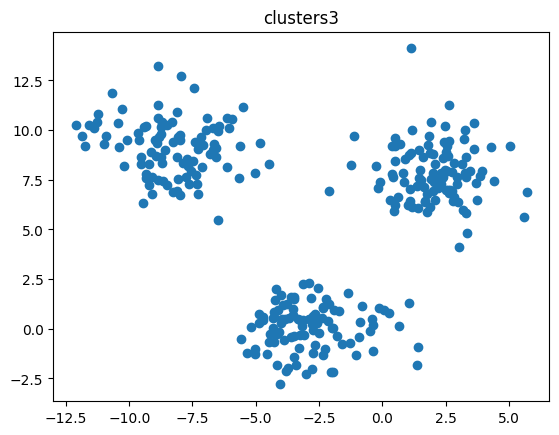

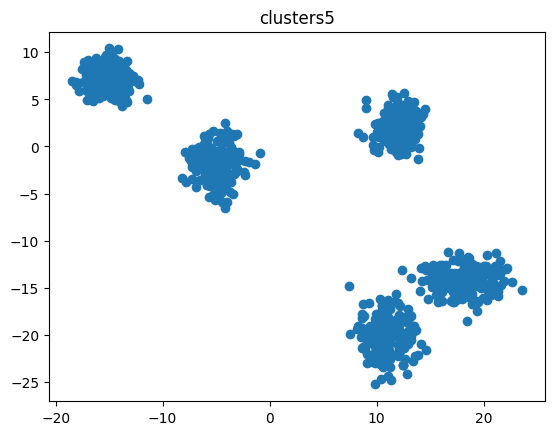

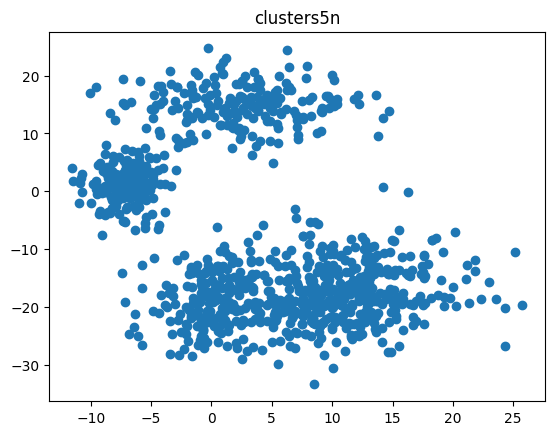

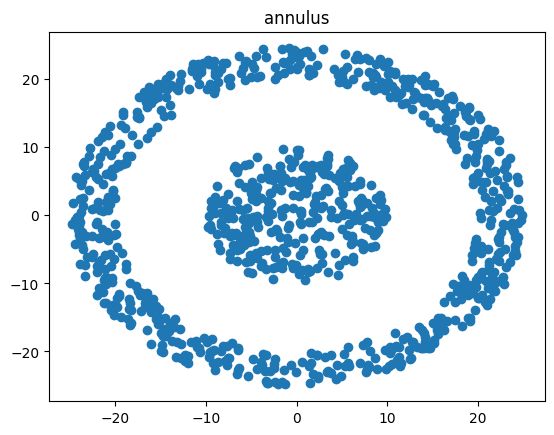

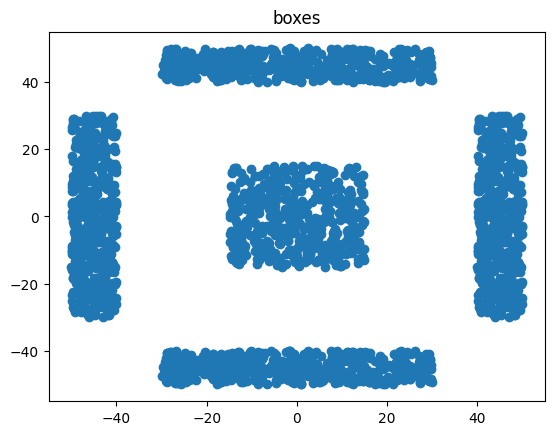

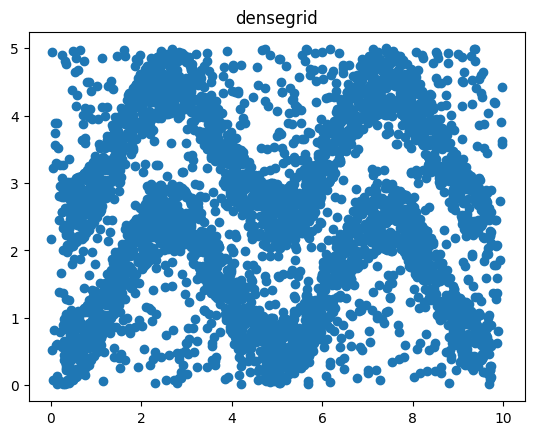

In [3]:
datasets = dict()
for data_file in ['clusters3', 'clusters5', 'clusters5n', 'annulus', 'boxes', 'densegrid']:
    data = np.loadtxt(f'{data_file}.csv', delimiter=';')
    datasets[data_file] = data
    plt.figure()
    plt.scatter(data[:, 0], data[:, 1])
    plt.title(data_file)

# 🔎 Why do we have multiple clustering methods?
* 🔎 Why isn't k-means enough?

![meme01](https://github.com/rasvob/VSB-FEI-Fundamentals-of-Machine-Learning-Exercises/blob/master/images/fml_05_meme_01.png?raw=true)

# 📊 Agglomerative clustering
- https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html
- Take a look at https://stats.stackexchange.com/questions/195446/choosing-the-right-linkage-method-for-hierarchical-clustering

* 💡 Agglomerative clustering is a **bottom-up approach** to clustering.
    * We first divide **each instance into its own cluster** and **merge them into couples** based on a similarity metric.
    * Subsequently we compute the **similarity** again and **merge the couples into bigger groups** (clusters).
    * These groups are then merged into the bigger ones **till there is only a one big group containing all the instances present at the top**.

### 🚀 **We don't have to know the number of clusters beforehand.**  
* 💡 We can perform the whole clustering process and **select the appropriate number of clusters afterward** based on the obtained results. 
* We usually use the **dendrogram** for the distance threshold estimation.

## 🔎 You may ask how is the similarity among groups computed. 
* 💡 **Similarity is pretty hard to define.**
* There are various ways how we can compute the value called **Linkage**.

![meme02](https://github.com/rasvob/VSB-FEI-Fundamentals-of-Machine-Learning-Exercises/blob/master/images/fml_05_meme_02.jpg?raw=true)

## 💡 Linkage variants
- **Maximum or Complete linkage**:
    - The distance between two clusters is defined as the maximum value of all pairwise distances between the elements in cluster 1 and the elements in cluster 2.
    - It tends to produce more compact clusters.
    - It is less prone to outliers than Single linkage.
    - Complete linkage methods tend to break large clusters.


- **Minimum or Single linkage**:
    - The distance between two clusters is defined as the minimum value of all pairwise distances between the elements in cluster 1 and the elements in cluster 2.
    - It tends to produce long, “loose” clusters.
    - Single linkage method is prone to "chain" and form clusters of irregular, often thread-like curved shapes.
        - The reason for that is obvious. With this method, at any step, **two clusters are merged if their closest edges are close enough**.
        - No proximity between other parts of the two clusters is taken into consideration.


- **Mean or Average linkage**:
    - The distance between two clusters is defined as the average distance between the elements in cluster 1 and the elements in cluster 2.

## We are going to take a look at dendrogram, but we will be using only smaller portion of data *clusters3* for now
* Use `np.random.choice` for choosing only 30 samples
* Check the shape of the data

In [4]:
# grab random 30
data = datasets['clusters3']
sel = np.random.choice(data.shape[0], size=30, replace=False)
data_subset = data[sel, :]
data_subset

array([[ -9.10848365,   7.6545282 ],
       [  3.94675686,   7.94270233],
       [  0.26760696,   0.77798066],
       [  3.21025299,   5.98937679],
       [ -6.80948887,   8.77433087],
       [  2.84407767,   6.65722529],
       [ -1.25188997,   8.22021811],
       [ -2.32980728,  -1.30249812],
       [ -8.10426442,   8.64992876],
       [ -4.46975786,   8.2919472 ],
       [ -6.67141676,   8.98645821],
       [ -8.26074889,   6.86055247],
       [  1.00850987,   6.25305591],
       [ -9.34259744,   7.8146591 ],
       [ -5.01155366,  -1.03331741],
       [ -8.74078631,   8.64534696],
       [ -3.7667896 ,   1.24861126],
       [ -3.25906907,   0.42968159],
       [ -4.82590133,   9.3274865 ],
       [  0.87346695,   7.40983885],
       [  3.32681759,   5.81617039],
       [ -9.1032414 ,   6.77662759],
       [ -0.08060149,   7.3988861 ],
       [ -7.6774239 ,   8.17639512],
       [ -4.01295428,   1.69660427],
       [ -8.10021615,  10.9075299 ],
       [ -7.13966144,   8.15727682],
 

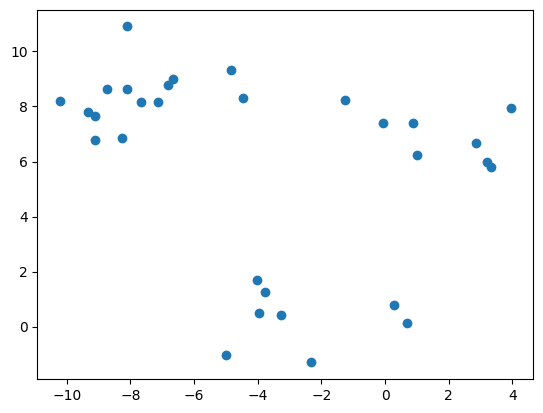

In [5]:
plt.scatter(data_subset[:, 0], data_subset[:, 1])

In [14]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    # Credit to https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    plt.title('Hierarchical Clustering Dendrogram')
    dendrogram(linkage_matrix, **kwargs)
    plt.ylabel('distance')

In [11]:
len(data_subset)

30

In [12]:
aggolo_clustering = AgglomerativeClustering(linkage='complete', distance_threshold=0, n_clusters=None)
clustering = aggolo_clustering.fit(data_subset)
clustering.children_

array([[ 3, 20],
       [ 4, 10],
       [ 0, 13],
       [16, 24],
       [23, 26],
       [ 8, 15],
       [17, 28],
       [ 2, 29],
       [11, 21],
       [19, 22],
       [ 5, 30],
       [ 9, 18],
       [27, 32],
       [31, 34],
       [33, 36],
       [12, 39],
       [35, 43],
       [ 1, 40],
       [38, 42],
       [ 7, 14],
       [25, 46],
       [ 6, 45],
       [44, 49],
       [48, 50],
       [47, 51],
       [41, 53],
       [37, 52],
       [54, 56],
       [55, 57]])

# 🎯 Complete linkage

## We need to calculate whole hiearchical clustering tree before dendrogram calculation

- 💡 We can achieve this by setting distance_threshold=0, n_clusters=None in sklearn.cluster.AgglomerativeClustering

- Notice the height of the vertcal lines in the denrogram - the higher the line (called fusion), the lower is the similarity between the clusters.
- This similarity is called cophenetic distance.

* In scikit.learn we have the `AgglomerativeClustering` class
    * Important parameters are *linkage, distance_threshold* and *n_clusters*
    * And also there is the *fit()* method as usual 

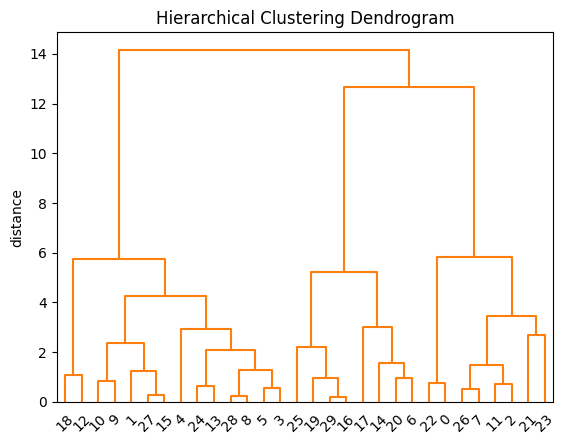

In [15]:
agglo_clustering = AgglomerativeClustering(linkage='complete', distance_threshold=0, n_clusters=None)
clustering = agglo_clustering.fit(data_subset)

plot_dendrogram(clustering, labels=clustering.labels_, color_threshold=999)

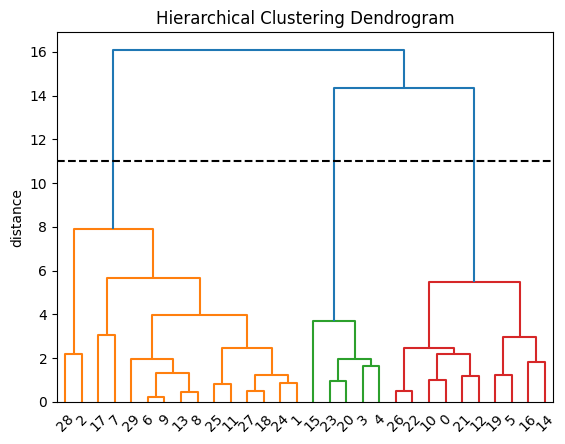

In [23]:
plot_dendrogram(clustering, labels=clustering.labels_, color_threshold=11)
plt.axhline(y=11, color='black', linestyle='--')

## 🔎 What can be an ideal level for splitting our data to clusters?

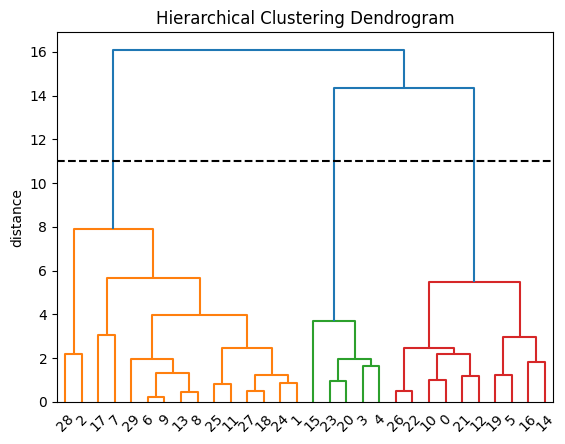

In [24]:
plot_dendrogram(clustering, labels=clustering.labels_, color_threshold=11)
plt.axhline(y=11, color='black', linestyle='--')

## 🚀 Create dendrogram for the full dataset

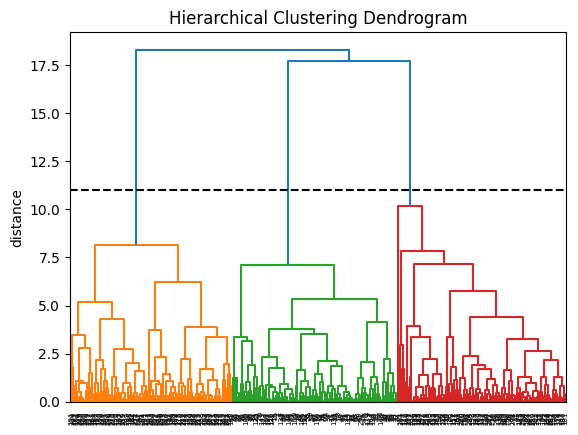

In [26]:
clustering = agglo_clustering.fit(data)

plot_dendrogram(clustering, labels=clustering.labels_, color_threshold=11)
plt.axhline(y=11, color='black', linestyle='--')

# Let's generate clustering results and use sccater plot for visualizion for our 2D toy datasets

* We can use **one of following parameters** to obtain our clusters from AgglomerativeClustering:
    - **distance_thrashold** - this is effectively the split line above
        - i.e. if the distance between two clusters is higher than the *distance_thrashold*, then these clusters won't be merged
    - **n_clusters** - similar to the k-means *k* parameter
 
## 💡 We can start with `distance_threshold` and set it to `11`

In [27]:
clustering = AgglomerativeClustering(
    linkage="complete", 
    distance_threshold=11,
    n_clusters=None
)

clustering.fit(data)

,n_clusters,None
,metric,'euclidean'
,memory,None
,connectivity,None
,compute_full_tree,'auto'
,linkage,'complete'
,distance_threshold,11
,compute_distances,False


In [16]:
data

array([[ -8.90462175,   9.34053331],
       [ -8.85412893,  10.61580326],
       [ -8.7502449 ,  10.17496414],
       [ -7.24246043,   9.18011444],
       [ -7.31404141,   7.26402986],
       [ -8.81604539,   9.63854214],
       [ -7.6774239 ,   8.17639512],
       [ -6.57788609,   8.6229914 ],
       [ -4.82590133,   9.3274865 ],
       [ -6.1167786 ,   8.1682598 ],
       [ -7.76696191,   7.63627563],
       [-11.0134539 ,   9.30821603],
       [-10.07957515,   9.50389878],
       [ -9.33952782,  10.20382807],
       [-10.6671012 ,  11.87014968],
       [-11.86199758,   9.70500412],
       [ -8.05271183,   9.64139559],
       [ -8.92418512,   8.69370897],
       [ -7.98224667,   9.52189884],
       [ -8.13000173,   6.9273213 ],
       [ -9.4616962 ,   6.35392598],
       [-11.21742883,  10.83122224],
       [ -8.10426442,   8.64992876],
       [-11.41017612,  10.11635296],
       [ -6.14857933,  10.62951099],
       [ -8.87744817,   7.50411482],
       [ -7.4602026 ,   8.43494765],
 

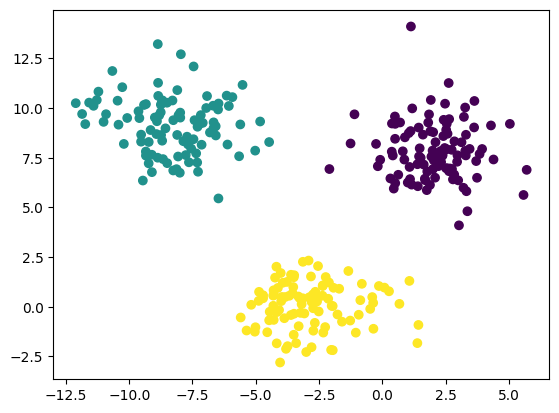

In [28]:
plt.scatter(data[:,0], data[:,1], c=clustering.labels_)

## 💡  We can also specify number of clusters directly
* Set `n_clusters` to `3`

In [18]:
agglo = AgglomerativeClustering(
    linkage="complete", 
    distance_threshold=None,
    n_clusters=3
)

agglo.fit(data)


,n_clusters,3
,metric,'euclidean'
,memory,None
,connectivity,None
,compute_full_tree,'auto'
,linkage,'complete'
,distance_threshold,None
,compute_distances,False


In [19]:
agglo.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

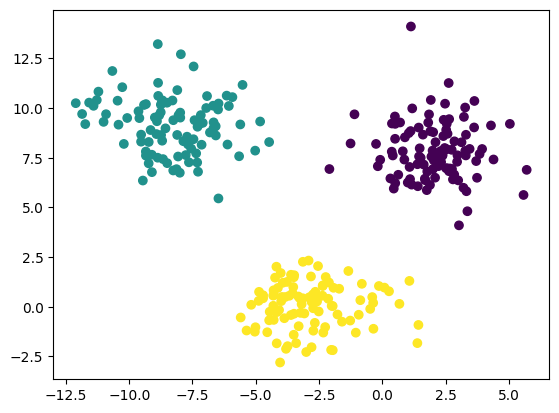

In [39]:
plt.scatter(data[:,0], data[:,1], c=agglo.labels_)

# 🎯 Single linkage

In [52]:
data[62]

array([-7.98524398,  9.77503816])

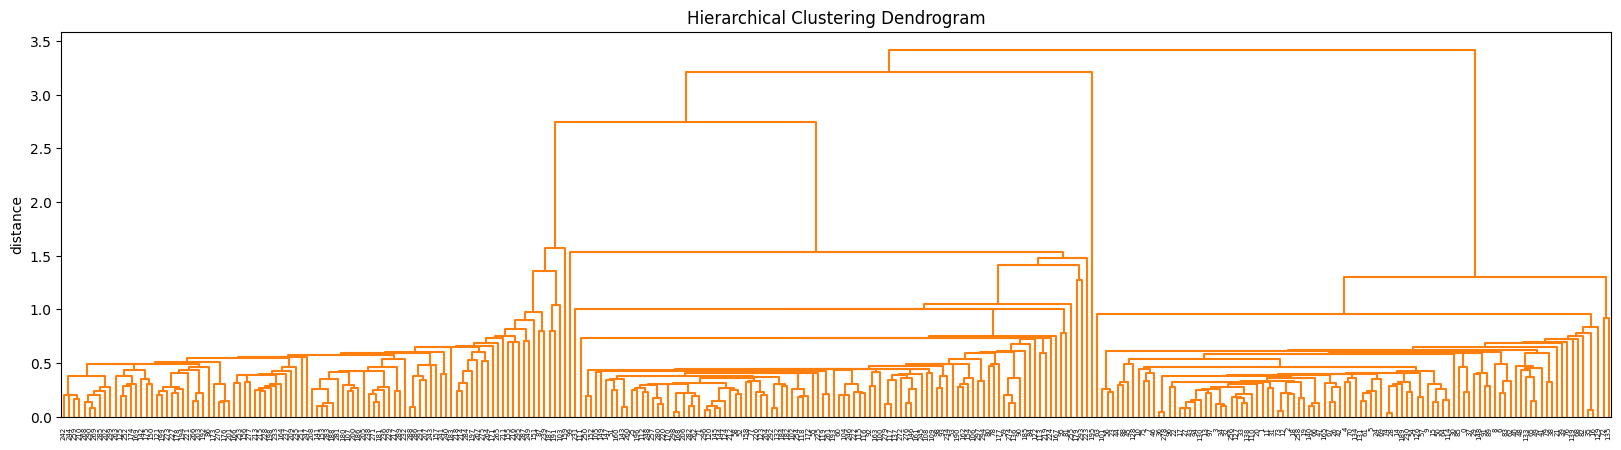

In [46]:
clustering = AgglomerativeClustering(
    linkage="single", 
    distance_threshold=0,
    n_clusters=None
)

clustering.fit(data)
plt.figure(figsize=(20, 5))
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(clustering, labels=clustering.labels_, color_threshold=999)

## 🔎 What is the appropriate number of clusters?
* Use `distance_threshold` to set it and take a look at how big are the clusters

In [59]:
clustering = AgglomerativeClustering(
    linkage="single", 
    distance_threshold=2,
    n_clusters=None
)

clustering.fit(data)

pd.Series(clustering.labels_).value_counts()

1    101
3    100
0     98
2      1
Name: count, dtype: int64

# 🔎 What is the difference between this and complete linkage?

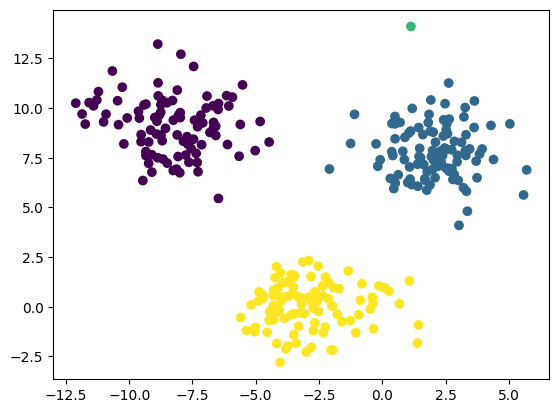

In [60]:
plt.scatter(data[:,0], data[:,1], c=clustering.labels_)

# We can use Agglomerative clustering for the annulus dataset as well

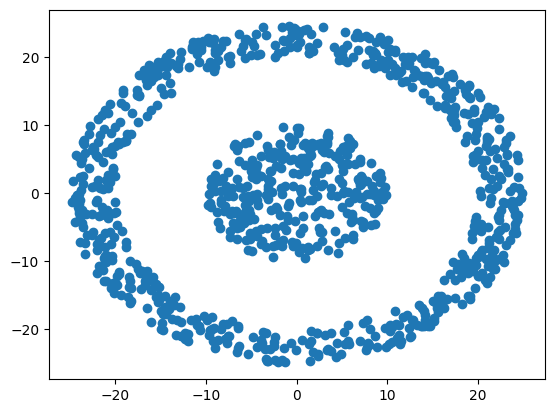

In [61]:
data = datasets['annulus']
plt.scatter(data[:,0], data[:,1])

# 🎯 Complete linkage

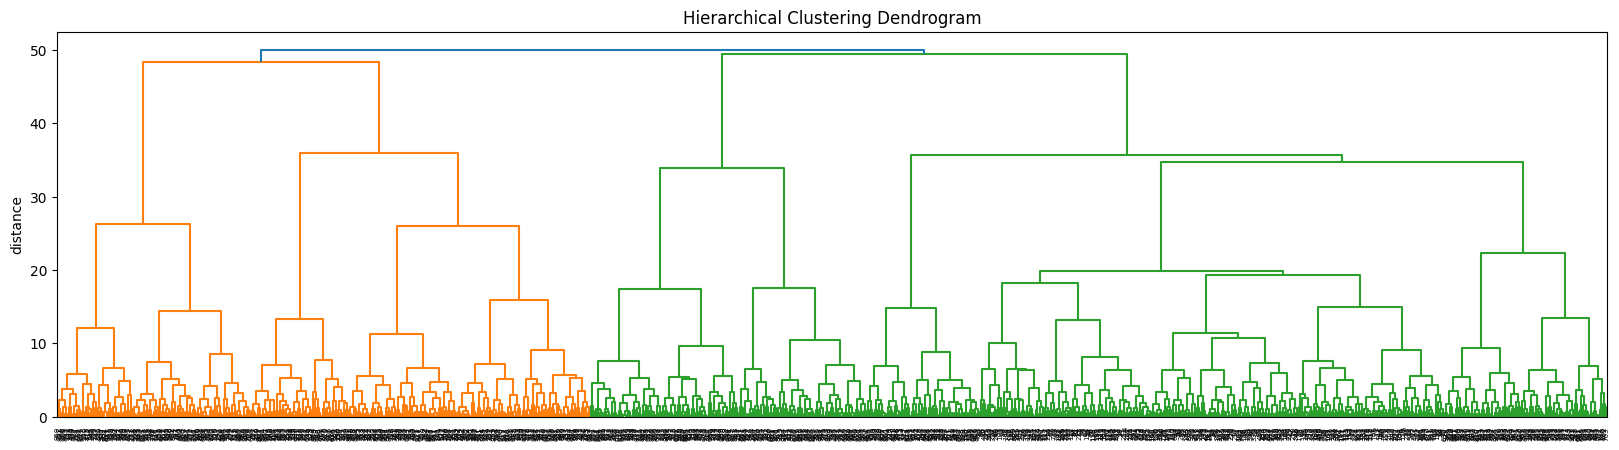

In [67]:
clustering = AgglomerativeClustering(linkage='complete', distance_threshold=0, n_clusters=None)
clustering = clustering.fit(data)

plt.figure(figsize=(20,5))
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(clustering, labels=clustering.labels_, color_threshold=49.9)

## Four clusters seems OK, so let's try it ✊

In [75]:
clustering = AgglomerativeClustering(linkage='complete', distance_threshold=49.9, n_clusters=None)
clustering = clustering.fit(data)
pd.Series(clustering.labels_).value_counts()

0    656
1    344
Name: count, dtype: int64

## Does it seem OK now?

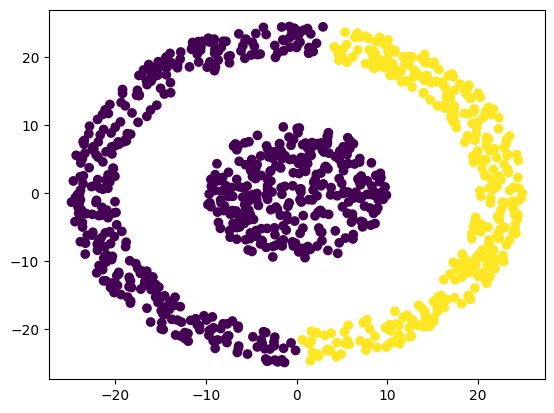

In [76]:
plt.scatter(data[:,0], data[:,1], c=clustering.labels_)

# 🎯 Single linkage

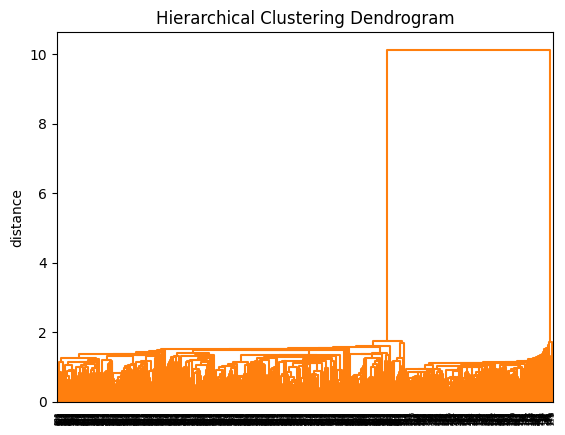

In [77]:
clustering = AgglomerativeClustering(linkage='single', distance_threshold=0, n_clusters=None)
clustering = clustering.fit(data)

plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(clustering, labels=clustering.labels_, color_threshold=999)
plt.show()

## Let's try with two clusters now

In [78]:
clustering = AgglomerativeClustering(linkage='single', distance_threshold=None, n_clusters=2)
clustering = clustering.fit(data)
pd.Series(clustering.labels_).value_counts()

0    700
1    300
Name: count, dtype: int64

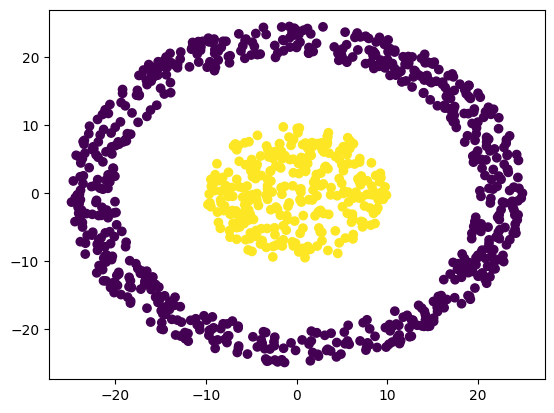

In [79]:
plt.scatter(data[:,0], data[:,1], c=clustering.labels_)

# 🚀 We have seen, that there is no clear winner among linkage parameters
- It depends solely on the dataset 
- **No Free Lunch Theorem** - see https://machinelearningmastery.com/no-free-lunch-theorem-for-machine-learning/

## For more clustering information you can take a look at [documentation](https://scikit-learn.org/stable/modules/clustering.html#clustering)

# ✅ Task (2p)
- Use **Agglomerative Clustering** on **clusters5** and **densegrid** datasets
- Detect "ideal" number of clusters using the dendrogram
- **Use both, the single and complete linkage and compare the results of the clustering methods**
    - How are the selected clusters aligned with the raw data (use scatter plots)?
    - i.e. You can guess the right number of clusters by taking a look at the data, but is the result of the algorithm right from your point of view?
 
* **Describe the insight you got from the plots with a few sentences in a Markdown cell below the plot**
  * ❌ Plot interpretation figured in real-time during task check is not allowed! ❌

# Dataset - Clusters 5

In [25]:
clusters5 = datasets['clusters5']
clusters5.shape

(1000, 2)

<Axes: >

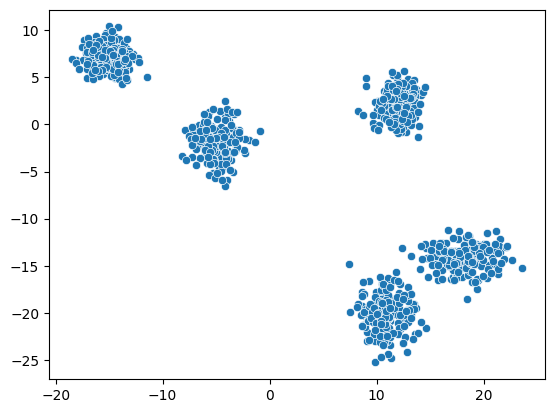

In [ ]:
sns.scatterplot(x=clusters5[:, 0], y=clusters5[:, 1])

Excpected number of clusters is 5. Let's try agglomerative clustering with every linkage method.

## Single linkage

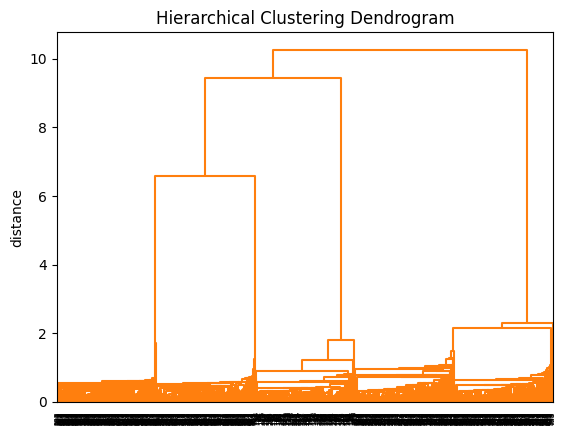

In [42]:
singleAgglo = AgglomerativeClustering(linkage='single', distance_threshold=0, n_clusters=None)
singleClustering = singleAgglo.fit(clusters5)

plot_dendrogram(singleClustering, labels=singleClustering.labels_, color_threshold=999)

We can see distinctly 4 clusters here, but want 5. Let's try tweaking the distance_threshold parameter.

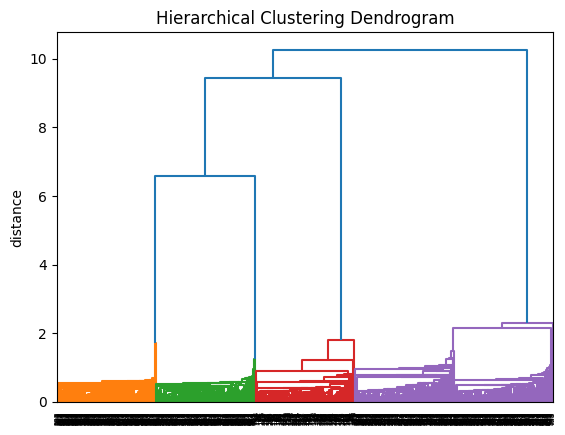

In [43]:
plot_dendrogram(singleClustering, labels=singleClustering.labels_, color_threshold=6)

In [ ]:
# Choose a method
singleAgglo = AgglomerativeClustering(
    linkage='single', 
    distance_threshold=None, 
    n_clusters=4
)

# Train on dataset 'clusters5'
# this variable only hold the labels, distance and so on from the training
# it doesn't contain the data (clusters5 data) itself
singleClustering = singleAgglo.fit(clusters5)

pd.Series(singleClustering.labels_).value_counts()

0    400
1    200
3    200
2    200
Name: count, dtype: int64

<Axes: >

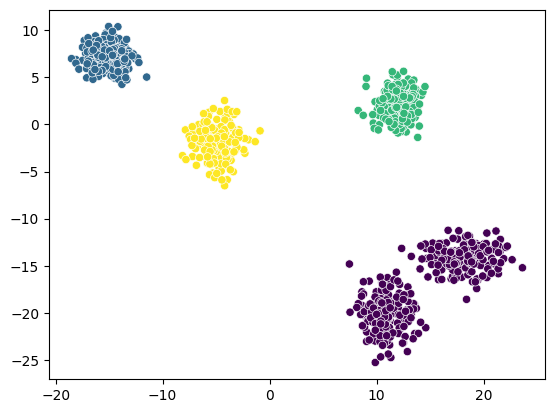

In [61]:
sns.scatterplot(x=clusters5[:,0], y=clusters5[:,1], c=singleClustering.labels_)

<Axes: >

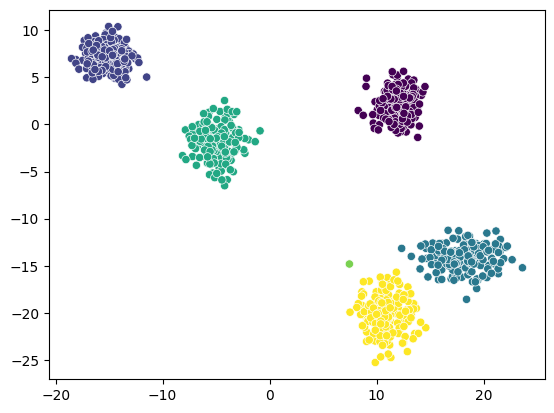

In [ ]:
single_agglo = AgglomerativeClustering(
    linkage='single', 
    distance_threshold=2.1, 
    n_clusters=None
)
single_clustering = single_agglo.fit(clusters5)

sns.scatterplot(x=clusters5[:,0], y=clusters5[:,1], c=single_clustering.labels_)

In [79]:
pd.Series(single_clustering.labels_).value_counts()

2    201
1    200
3    200
0    200
5    198
4      1
Name: count, dtype: int64

This looks much more promising except of that one point lying outside the Yellow cluster.

# Complete linkage method

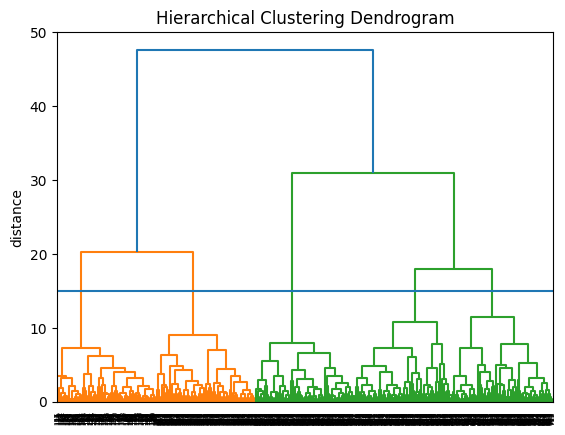

In [96]:
complete_agglo = AgglomerativeClustering(
    linkage='complete', 
    distance_threshold=0, 
    n_clusters=None
)
complete_clustering = complete_agglo.fit(clusters5)

plot_dendrogram(complete_clustering)
plt.axhline(y=15)

In [99]:
complete_agglo = AgglomerativeClustering(
    linkage='complete', 
    distance_threshold=15, 
    n_clusters=None
)
complete_clustering = complete_agglo.fit(clusters5)
pd.Series(complete_clustering.labels_).value_counts()

0    201
3    200
4    200
2    200
1    199
Name: count, dtype: int64

<Axes: >

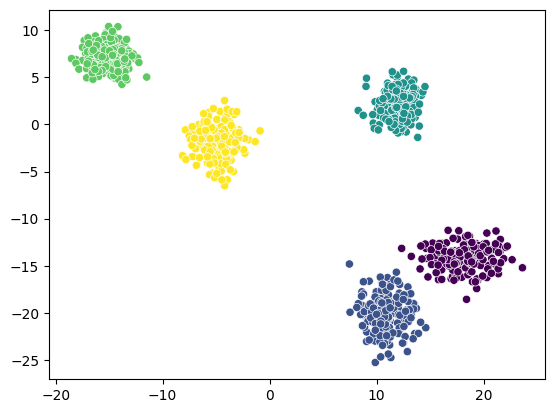

In [100]:
sns.scatterplot(x=clusters5[:,0], y=clusters5[:,1], c=complete_clustering.labels_)

We got 5 clusters, just like we wanted.

## Ward linkage method

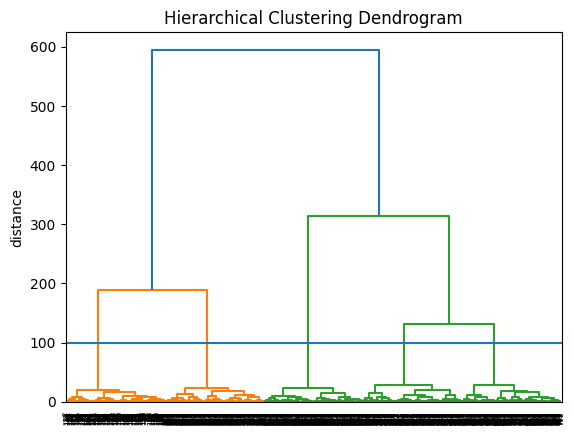

In [85]:
ward_agglo = AgglomerativeClustering(
    linkage='ward', 
    distance_threshold=0, 
    n_clusters=None
)
ward_clustering = ward_agglo.fit(clusters5)

plot_dendrogram(ward_clustering)
plt.axhline(y=100)

This could be it. The distandes seem reasonable. Most of the time the clusters are far appart and there are two clusters that are close one another.

In [87]:
ward_agglo = AgglomerativeClustering(
    linkage='ward', 
    distance_threshold=None, 
    n_clusters=5
)
ward_clustering = ward_agglo.fit(clusters5)
pd.Series(ward_clustering.labels_).value_counts()

0    201
3    200
4    200
2    200
1    199
Name: count, dtype: int64

<Axes: >

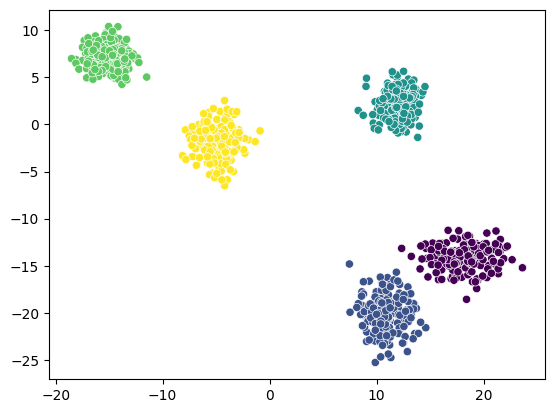

In [92]:
sns.scatterplot(x=clusters5[:,0], y=clusters5[:,1], c=ward_clustering.labels_)

This is exactly what we want - 5 clusters.

# Dataset - Densegrid

In [105]:
densegrid = datasets['densegrid']
densegrid

array([[2.308, 0.036],
       [9.967, 4.423],
       [9.074, 3.66 ],
       ...,
       [9.163, 1.235],
       [2.697, 2.292],
       [6.691, 1.851]], shape=(4000, 2))

<Axes: >

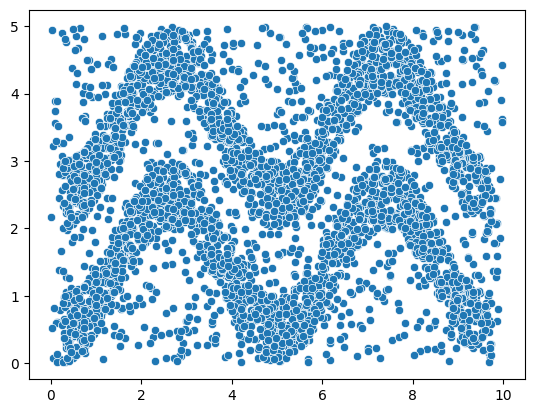

In [106]:
sns.scatterplot(x=densegrid[:,0], y=densegrid[:,1])

Here we expect 2 BIG clusters and BUNCH of small clusters or singleton clusters.

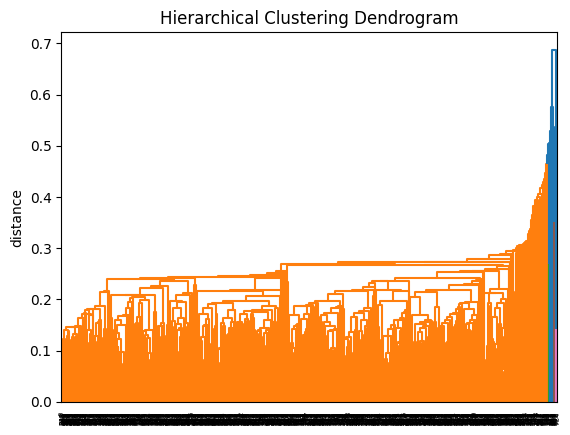

In [ ]:
single_agglo = AgglomerativeClustering(
    linkage='single',
    distance_threshold=0,
    n_clusters=None,
)

densegrid_subset = densegrid[np.random.choice(densegrid.shape[0], 1000)]

single_clustering = single_agglo.fit(densegrid_subset)

plot_dendrogram(single_clustering)

We can't read shit from this. Let's just plot it out and see what clusters it produced.

In [121]:
pd.Series(single_clustering.labels_).value_counts()

551    1
767    1
959    1
527    1
703    1
      ..
4      1
3      1
2      1
1      1
0      1
Name: count, Length: 1000, dtype: int64

<Axes: >

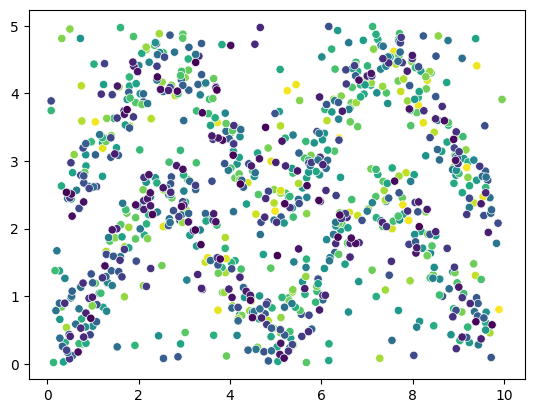

In [119]:
sns.scatterplot(x=densegrid_subset[:,0], y=densegrid_subset[:,1], c=single_clustering.labels_)

Doesn't look like anything we want. Tweak the distance_threshold.

In [ ]:
single_agglo = AgglomerativeClustering(
    linkage='single',
    distance_threshold=0.31,
    n_clusters=None,
)

densegrid_subset = densegrid[np.random.choice(densegrid.shape[0], 1000)]

single_clustering = single_agglo.fit(densegrid_subset)
pd.Series(single_clustering.labels_).value_counts()

4     483
1     442
5       6
10      4
6       4
14      4
13      3
2       3
8       3
7       2
11      2
0       2
18      2
3       2
19      2
9       2
20      2
37      2
39      2
28      2
31      1
40      1
45      1
36      1
43      1
34      1
21      1
33      1
26      1
44      1
25      1
29      1
30      1
38      1
12      1
24      1
23      1
27      1
22      1
35      1
17      1
16      1
32      1
15      1
42      1
41      1
Name: count, dtype: int64

<Axes: >

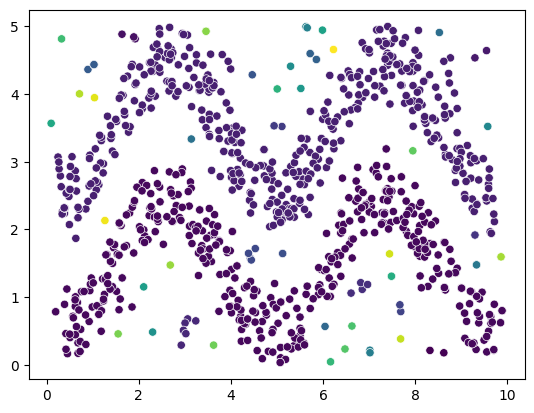

In [139]:
sns.scatterplot(x=densegrid_subset[:,0], y=densegrid_subset[:,1], c=single_clustering.labels_)

Looks good. We can run this on the full dataset now.

In [166]:
single_agglo = AgglomerativeClustering(
    linkage='single',
    distance_threshold=0.154,
    n_clusters=None,
)

single_clustering = single_agglo.fit(densegrid)
pd.Series(single_clustering.labels_).value_counts().head(10)

0     1791
2     1784
20      16
1       13
23       9
3        8
24       7
32       7
4        6
12       6
Name: count, dtype: int64

<Axes: >

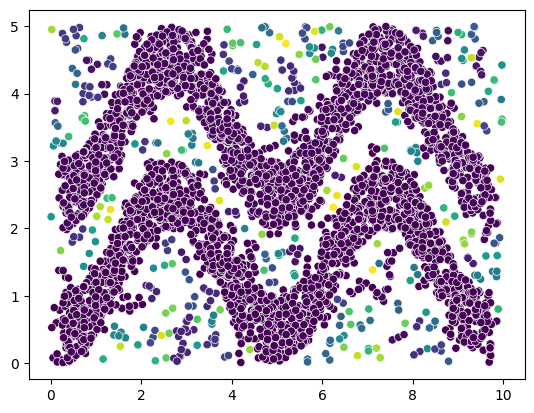

In [ ]:
sns.scatterplot(x=densegrid[:,0], y=densegrid[:,1])

This looks right but im not entirely sure. Let's plot only the waves and see if they contain only the correct points.

In [170]:
pd.Series(single_clustering.labels_).value_counts().head(2)

0    1791
2    1784
Name: count, dtype: int64

In [176]:
densegrid_df = pd.DataFrame(densegrid)
densegrid_df.head(10)

,0,1
0,2.308,0.036
1,9.967,4.423
2,9.074,3.660
3,6.626,0.575
4,5.122,1.645
5,6.003,1.421
6,9.548,4.640
7,7.603,2.702
8,1.553,3.496
9,2.050,2.024


In [184]:
densegrid_df['cluster'] = single_clustering.labels_
densegrid_df

,0,1,cluster
0,2.308,0.036,131
1,9.967,4.423,103
2,9.074,3.660,165
3,6.626,0.575,149
4,5.122,1.645,93
...,...,...,...
3995,4.370,1.314,0
3996,7.825,2.619,0
3997,9.163,1.235,0
3998,2.697,2.292,0


In [ ]:
# Two biggest clusters
biggest_clusters = pd.Series(single_clustering.labels_).value_counts().head(2)
biggest_clusters.keys()

first_cluster = densegrid_df.loc[densegrid_df['cluster'] == biggest_clusters.keys()[0]]
second_cluster = densegrid_df.loc[densegrid_df['cluster'] == biggest_clusters.keys()[1]]

<Axes: xlabel='0', ylabel='1'>

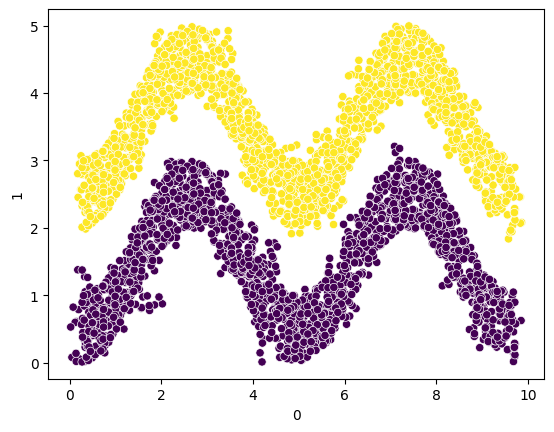

In [ ]:
biggest_clustsers = pd.concat([first_cluster, second_cluster])

sns.scatterplot(
    x=biggest_clustsers[0], 
    y=biggest_clustsers[1],
    c=biggest_clustsers['cluster'],
)

The wavs looks correct, they don't contain any 'outlier' point or anything like that.

## Complete linkage method


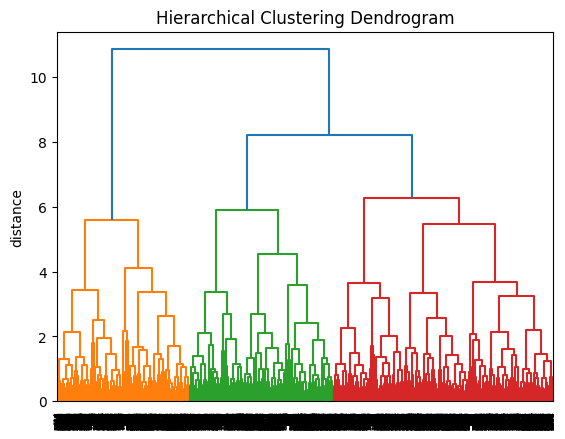

In [219]:
complete_agglo = AgglomerativeClustering(
    linkage='complete',
    distance_threshold=0,
    n_clusters=None,
)

complete_clustering = complete_agglo.fit(densegrid)
plot_dendrogram(complete_clustering)

Complete linkage method produced much more reasonable dendrogram, altough that doesn't mean anything yet. Let's plot it and see for ourselves.

<Axes: >

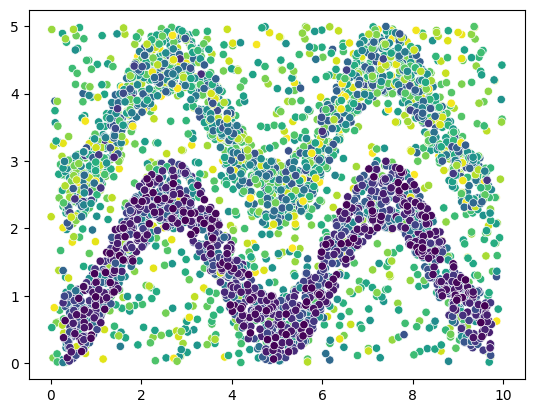

In [220]:
sns.scatterplot(x=densegrid[:,0], y=densegrid[:,1], c=complete_clustering.labels_)

In [236]:
complete_agglo = AgglomerativeClustering(
    linkage='complete',
    distance_threshold=2.9,
    n_clusters=None,
)

complete_clustering = complete_agglo.fit(densegrid)
pd.Series(complete_clustering.labels_).value_counts().head(10)

4     375
6     344
1     342
2     299
10    291
12    272
5     263
3     260
7     252
13    250
Name: count, dtype: int64

I tried to tweak the distance_threshold, but to no avail. The clusters are always about the same size, whereas we clearly want 2 BIG clusters and a lot of small or singleton clusters. This method doesn't seem to be able to produce the result we are after.

<Axes: >

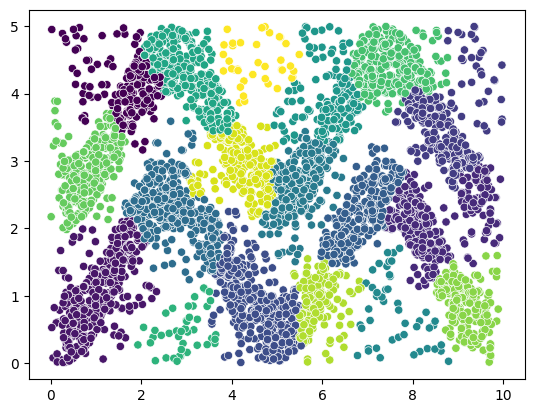

In [237]:
sns.scatterplot(x=densegrid[:,0], y=densegrid[:,1], c=complete_clustering.labels_)